# Notebook 2: NW-flex for X = A·Z·B

## Overview
In this notebook we build directly on the basic NW-flex core:

- We define an A·Z·B locus

  $$
  X = A \cdot Z \cdot B
  $$

  and a read $Y$.
- We construct three extra-predecessor patterns $E(i)$:
  - standard global NW (no extra predecessors),
  - a single flexible block on $Z$,
  - a semiglobal configuration (global in $Y$, local in $X$).
- We run the NW-flex DP core with each $E(i)$, compare scores and
  alignments, and visualize the DP matrices and paths.

We work directly with `run_flex_dp` so that the effect of the
extra predecessors is explicit in the code.

## Setup and imports


In [1]:
# 🧙 Notebook magic: autoreload modules
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

from nwflex.dp_core import FlexInput, run_flex_dp
from nwflex.ep_patterns import (
    build_EP_standard,
    build_EP_single_block,
    build_EP_semiglobal,
)
from nwflex.validation import get_default_scoring
from nwflex.plot import (
    plot_flex_matrices,
    plot_score_system,
    plot_ep_comparison,
    build_AZB_regions,
)
from nwflex.dp_core import AlignmentResult

## X = A·Z·B locus and scoring

We specify the A·Z·B decomposition explicitly and then form the full
reference and read:

- $A = \texttt{G}$
- $Z = \texttt{ATTA}$
- $B = \texttt{CA}$

so that

\begin{align*}
X &= \texttt{GATTACA} &= & A \cdot Z \cdot B \\
Y &= \texttt{GTTCA}     &= & A \cdot Z^* \cdot B, \quad Z^* = \texttt{TT} \subseteq Z
\end{align*}


In [2]:

# Reference X and read Y
A = "G"
Z = "ATTA"
B = "CA"

X = A + Z + B
Zstar = "TT"
Y = A + Zstar + B

print("X (reference):", X)
print("Y (read):     ", Y)

# Indices for the flexible block Z
s = len(A)
e = len(A) + len(Z)
print("Block indices: s =", s, "e =", e)
print("A =", X[:s], "Z =", X[s:e], "B =", X[e:])



X (reference): GATTACA
Y (read):      GTTCA
Block indices: s = 1 e = 5
A = G Z = ATTA B = CA


### Scoring
We use the default scoring scheme:

- match: $+5$
- mismatch: $-5$
- gap start: $-20$
- gap extend: $-1$


Score matrix:
 [[ 5 -5 -5 -5]
 [-5  5 -5 -5]
 [-5 -5  5 -5]
 [-5 -5 -5  5]]
gap_open: -20.0
gap_extend: -1.0
alphabet_to_index: {'A': 0, 'C': 1, 'G': 2, 'T': 3}


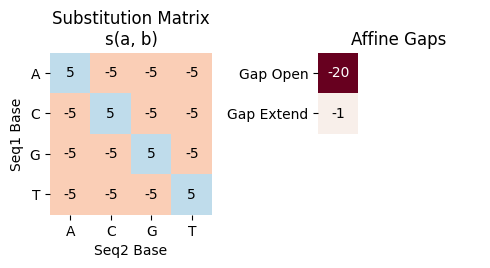

In [3]:
# Scoring scheme
score_matrix, gap_open, gap_extend, alphabet_to_index = get_default_scoring()

# Display the default score scheme:
clean_map = {str(k): v for k, v in alphabet_to_index.items()}
print("Score matrix:\n", score_matrix.astype(int))
print("gap_open:", gap_open)
print("gap_extend:", gap_extend)
print("alphabet_to_index:", clean_map)
fig = plot_score_system(score_matrix, gap_open, gap_extend, alphabet_to_index)
plt.show()

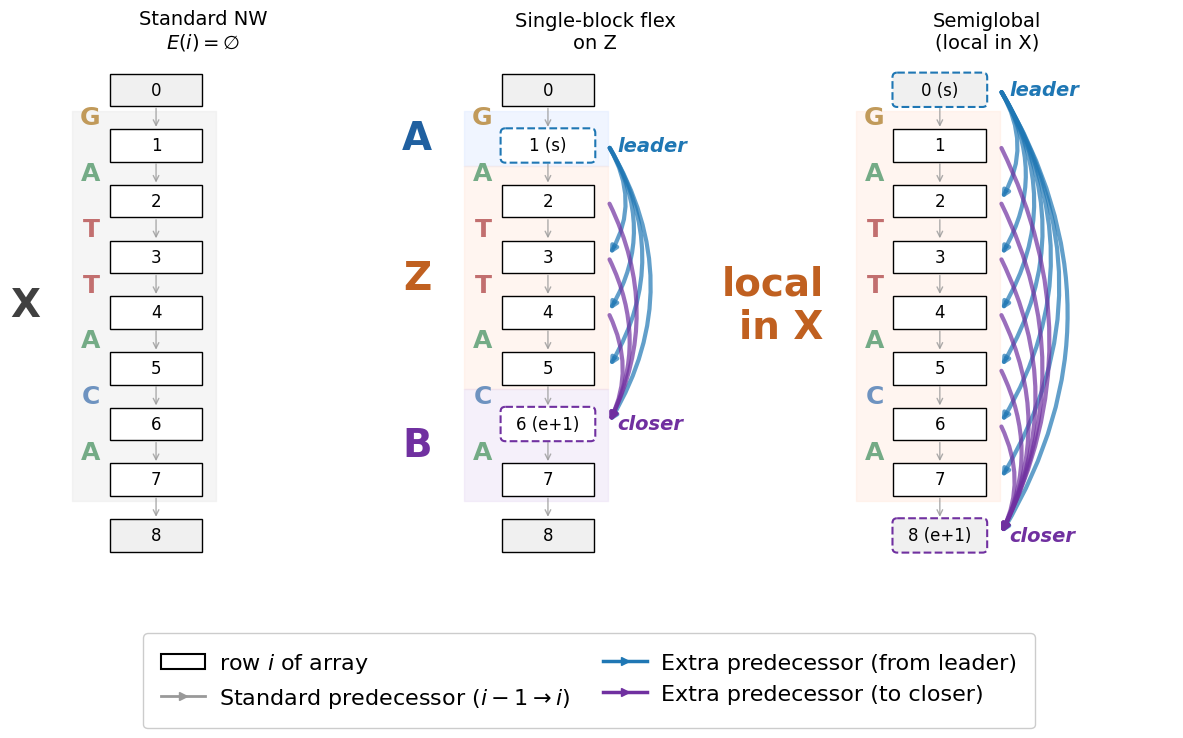

In [4]:

n = len(X)

# Build the three EP patterns
EP_standard = build_EP_standard(n)
EP_block = build_EP_single_block(n, s, e)
EP_semiglobal = build_EP_semiglobal(n)

# For plotting, define leaders for each pattern:
# - Standard NW: no leaders (no EP edges)
# - Single-block: leader row is s (edges from s skip into Z)
# - Semiglobal: leader row is 0 (edges from source skip into X)
leaders_list = [
    [],    # Standard NW: no leaders
    [s],   # Single-block: s is the leader
    [0],   # Semiglobal: 0 is the leader  
]

# Define background regions (A·Z·B decomposition)
# Colors: A=blue, Z=orange, B=purple, X=grey
color_A, color_Z, color_B, color_X = "#d0e0ff", "#ffe0d0", "#e0d0f0", "#e0e0e0"
label_A, label_Z, label_B, label_X = "#2060a0", "#c06020", "#7030a0", "#404040"

bg_standard = [
    {'start': 1, 'end': n, 'color': color_X,
     'label': 'X', 'label_color': label_X},
]
bg_block = [
    {'start': 1, 'end': s, 'color': color_A,
     'label': 'A', 'label_color': label_A},
    {'start': s + 1, 'end': e, 'color': color_Z,
     'label': 'Z', 'label_color': label_Z},
    {'start': e + 1, 'end': n, 'color': color_B,
     'label': 'B', 'label_color': label_B},
]
bg_semiglobal = [
    {'start': 1, 'end': n, 'color': color_Z,
     'label': 'local\nin X', 'label_color': label_Z},
]

backgrounds = [bg_standard, bg_block, bg_semiglobal]

# Row annotations (for labeling special rows)
# For single-block: leader is s, closer is e+1
# For semiglobal: leader is 0 (s=0), closer is n+1 (e+1 where e=n)
annot_standard = {}
annot_block = {s: "(s)", e + 1: "(e+1)"}
annot_semiglobal = {0: "(s)", n + 1: "(e+1)"}

row_annotations = [annot_standard, annot_block, annot_semiglobal]

# Titles
titles = [
    "Standard NW\n$E(i) = \\varnothing$",
    "Single-block flex\non Z",
    "Semiglobal\n(local in X)",
]

# Plot with styling matched to the DAG plot
# Boxes are sized to match DAG: 2 columns wide, 1 row tall
# row_spacing > node_height creates gaps for standard edges
fig = plot_ep_comparison(
    EP_list=[EP_standard, EP_block, EP_semiglobal],
    leaders_list=leaders_list,
    titles=titles,
    X=X,
    backgrounds=backgrounds,
    row_annotations_list=row_annotations,
    figsize=(12, 14),
    wspace=0.05,
    # Match DAG plot styling
    closer_edge_color="#7030a0",
    leader_curvature=0.3,
    closer_curvature=0.25,
    ep_linewidth=3.0,
    sequence_fontsize=18.0,  # Match DAG
    sequence_fontweight="semibold",
    region_fontsize=28.0,
    row_label_fontsize=12.0,
    row_label_fontweight="normal",  # Not bold
    legend_fontsize=16.0,
    # Box sizing and spacing
    node_width=2.0,      # 2 DAG columns wide
    node_height=0.7,     # Slightly shorter than row_spacing
    row_spacing=1.2,     # More space between rows for standard edges
    box_label_fontsize=14.
)
plt.show()

### Interpreting the EP patterns

The three panels above illustrate how extra predecessors modify the DP graph:

- **Standard NW** (left): No EP edges. Every row $i$ has only its standard 
  predecessor $i-1$. The DP proceeds row by row with no shortcuts.

- **Single-block flex** (center): Row $s=2$ is the leader. Blue edges from $s$ 
  reach into the flexible region $Z$, allowing the DP to skip the beginning of $Z$.
  Purple edges from rows within $Z$ converge at the closer row $e+1=9$, allowing 
  the DP to exit $Z$ early. Together, these edges let NW-flex align any 
  contiguous substring $Z^* \subseteq Z$.

- **Semiglobal** (right): Row $0$ is the leader for the entire sequence. Blue 
  edges from the source reach every row, allowing alignment to start anywhere in $X$.
  Purple edges from all rows converge at the final row, allowing alignment to end 
  anywhere. This realizes "local in $X$, global in $Y$" alignment.

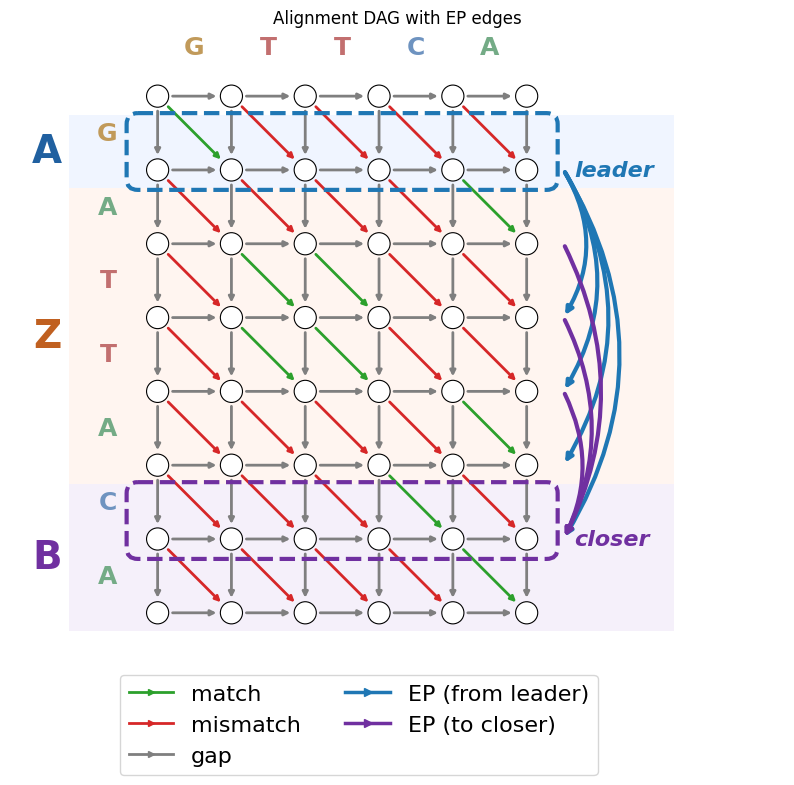

In [5]:
# Single-panel DAG with EP arcs on the right
from nwflex.plot import plot_dag_with_ep_arcs

fig_dag_ep = plot_dag_with_ep_arcs(
    EP=EP_block,
    leaders=[s],
    X=X,
    Y=Y,
    s=s,
    e=e,
    node_radius = 0.15,
    figsize=(10, 10),
    color_A=color_A,
    color_Z=color_Z,
    color_B=color_B,
    label_A=label_A,
    label_Z=label_Z,
    label_B=label_B,
    closer_edge_color="#7030a0",
    leader_curvature=0.3,
    closer_curvature=0.25,
    title="Alignment DAG with EP edges",
    dag_linewidth=2.0,
    ep_linewidth=3.0,
    sequence_fontweight="semibold",
    region_fontsize=28.0,
    box_label_fontsize=16.0,
    legend_fontsize=16.0,
    legend_bbox_to_anchor=(0.45, -0.18)
    
)

plt.show()

### The alignment DAG with EP edges

The figure above shows the alignment DAG for $X = A \cdot Z \cdot B$ and $Y$, 
augmented with extra predecessor (EP) edges on the right margin:

- **Standard DAG edges** (interior): Gray horizontal/vertical edges represent 
  gaps; green/red diagonals represent matches/mismatches. These connect 
  adjacent cells $(i,j) \to (i+1,j+1)$, $(i,j) \to (i+1,j)$, or $(i,j) \to (i,j+1)$.

- **EP edges** (right margin): Curved arcs connecting non-adjacent rows.
  - **Leader edges** (blue): From row $s$ into the flexible block $Z$. These 
    allow the DP to "jump into" $Z$ from the leader row.
  - **Closer edges** (purple): From rows within $Z$ to the closer row $e+1$. 
    These allow the DP to "jump out" of $Z$ to resume global alignment in $B$.

- **Region shading**: The A·Z·B decomposition is shown as horizontal bands — 
  blue for $A$, orange for $Z$, purple for $B$.

The EP edges act on **entire rows**: when the DP uses a leader edge from row 
$s$ to row $i > s+1$, it skips the intervening characters of $X$ without 
paying gap penalties. This is what enables NW-flex to find the best 
contiguous substring $Z^* \subseteq Z$ in a single pass.

## Running the NW-flex core

We wrap `run_flex_dp` in a small helper that takes $(X, Y, E)$ and
returns the score, aligned sequences, the DP path, the row jumps,
and the full DP state.

We then run:

- standard NW (EP_standard),
- single-block NW-flex (EP_block),
- semiglobal NW-flex (EP_semiglobal),

and compare their scores and alignments.

In [6]:
def run_with_EP(X, Y, EP):
    """Run NW-flex DP with a given EP pattern and return the result."""
    config = FlexInput(
        X=X,
        Y=Y,
        score_matrix=score_matrix,
        gap_open=gap_open,
        gap_extend=gap_extend,
        extra_predecessors=EP,
        alphabet_to_index=alphabet_to_index,
    )
    res = run_flex_dp(
        config,
        return_data=True,
    )    
    return config, res


# Run alignment with each EP pattern
cfg_std, res_std = run_with_EP(X, Y, EP_standard)
cfg_blk, res_blk = run_with_EP(X, Y, EP_block)
cfg_sg,  res_sg  = run_with_EP(X, Y, EP_semiglobal)

print("Standard NW score:", res_std.score)
print(res_std.X_aln)
print(res_std.Y_aln)
print()

print("Single-block NW-flex score:", res_blk.score, sep="\n")
print(res_blk.X_aln)
print(res_blk.Y_aln)
print("Row jumps:", *res_blk.jumps, sep="\n")
print()

print("Semiglobal NW-flex score:", res_sg.score, sep="\n")
print(res_sg.X_aln)
print(res_sg.Y_aln)
print("Row jumps:", *res_sg.jumps, sep="\n")

Standard NW score: -6.0
GATTACA
G--TTCA

Single-block NW-flex score:
25.0
GTTCA
GTTCA
Row jumps:
RowJump(from_row=1, to_row=3, col=2, state=1)
RowJump(from_row=4, to_row=6, col=4, state=1)

Semiglobal NW-flex score:
5.0
GATTA
GTTCA
Row jumps:
RowJump(from_row=8, to_row=5, col=5, state=1)


In this example:

- Standard NW must pay for deleting part of $Z$ with gaps.
- The single-block EP pattern lets the DP jump over a substring of $Z$
  and treat it as unaligned, effectively aligning $A \cdot Z^* \cdot B$.
- The semiglobal EP pattern is more permissive at the ends: the entire $X$ can
  flex, which is appropriate when we want to align the whole read $Y$ 
  to any part of the reference sequence $X$.

## Visualizing the DP matrices and paths

We now visualize the $Y_g$, $M$, and $X_g$ score layers for each configuration
using `plot_flex_matrices`, highlighting:

- the flexible block rows (for the $ A·Z·B $ case), and
- the best DP path and row jumps that arise from extra predecessors.
- the start and end positions of the optimal internal substring $Z^*$.

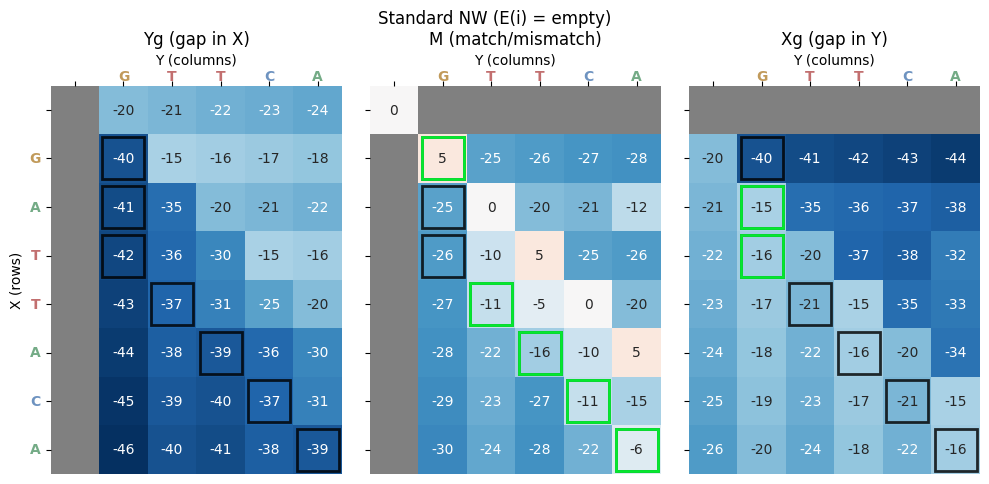

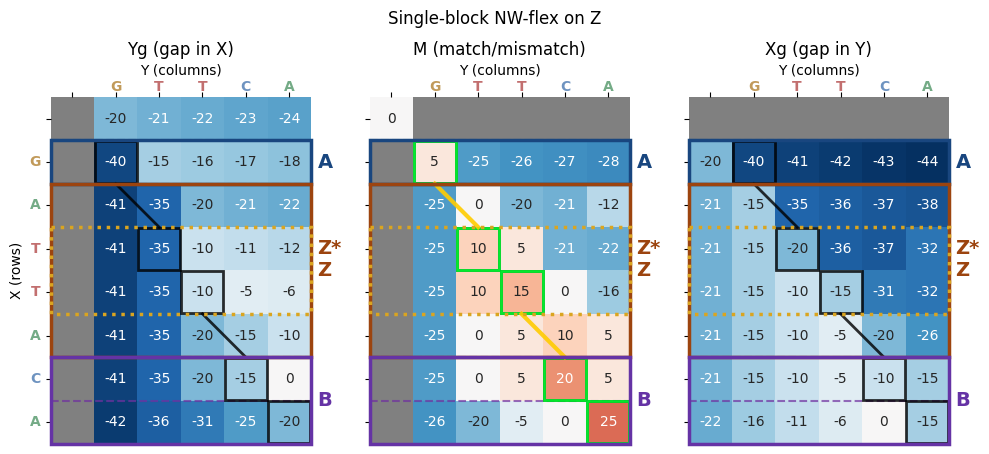

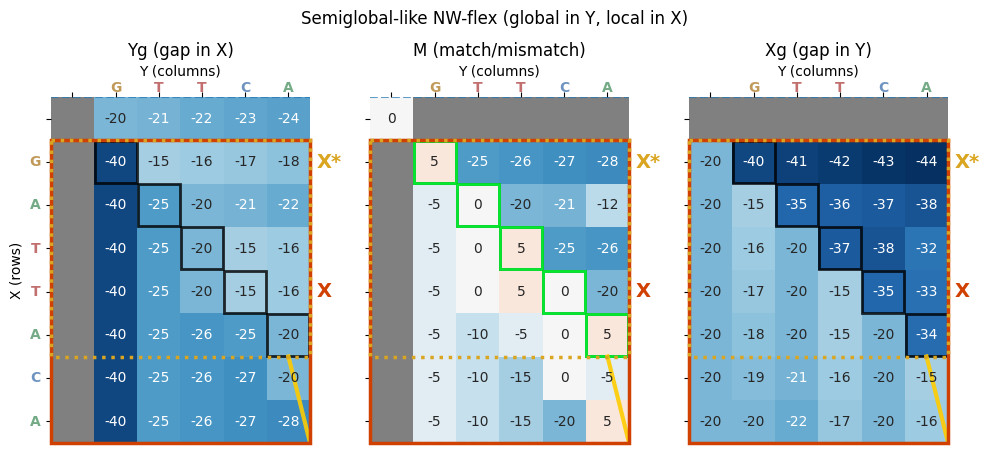

In [9]:
fig_size = (10, 5)
ms = 30
GOLD = '#DAA520'  # Gold color matching jump edges

# Standard NW (no region boxes - standard NW doesn't use A·Z·B decomposition)
# (no start and end rows (start before -1 and end after n))
fig_std = plot_flex_matrices(
    result=res_std,
    X=X,
    Y=Y,
    s=-2,
    e=n+1,
    marker_size=ms,
    figsize=fig_size,
)
fig_std.suptitle("Standard NW (E(i) = empty)")
fig_std.tight_layout(w_pad=2.0)
plt.show()

# Single-block NW-flex with A·Z·B region boxes
# Get Z* boundaries from alignment jumps
# jumps[0] is entry jump (from A into Z*), jumps[1] is exit jump (from Z* to B)
entry_jump = res_blk.jumps[0]  # Jump from row s (last of A) into Z*
exit_jump = res_blk.jumps[1]   # Jump from Z* to row e+1 (first of B)
zstar_start = entry_jump.to_row   # First row of Z* (where we land after entry)
zstar_end = exit_jump.from_row    # Last row of Z* (where we jump from)

regions_block = build_AZB_regions(s=s, e=e, n=len(X))
# Add Z* as a dotted gold box inside Z, with label at top
regions_block.append({
    'start': zstar_start, 'end': zstar_end,
    'label': 'Z*', 'color': GOLD,
    'linestyle': ':', 'label_position': 'top',
})
fig_blk = plot_flex_matrices(
    result=res_blk,
    X=X,
    Y=Y,
    s=s,
    e=e,
    marker_size=ms,
    figsize=fig_size,
    regions=regions_block,
)
fig_blk.suptitle("Single-block NW-flex on Z")
fig_blk.tight_layout(w_pad=2.0)
plt.show()

# Semiglobal NW-flex visualization:
# here the flexible block spans all of X (s=0, e=n), so only X region shown
# Get X* boundaries from alignment jumps
# 
# For semiglobal, we need to check for two types of jumps:
# 1. Terminal jump: from_row = n+1 (virtual) -> to_row = actual end row (xstar_end)
# 2. Entry jump: from_row = 0 (leader) -> to_row = actual start row (xstar_start)
#
# If there's no entry jump from row 0, alignment starts at row 1.
# If there's no terminal jump to a row < n, alignment ends at row n.

n_sg = len(X)

# Find terminal jump (from virtual row n+1) to determine xstar_end
terminal_jump = None
for jmp in res_sg.jumps:
    if jmp.from_row == n_sg + 1:
        terminal_jump = jmp
        break

# Find entry jump (from leader row 0) to determine xstar_start
entry_jump_sg = None
for jmp in res_sg.jumps:
    if jmp.from_row == 0 and jmp.to_row > 1:
        entry_jump_sg = jmp
        break

# Determine X* boundaries
xstar_start = entry_jump_sg.to_row if entry_jump_sg is not None else 1
xstar_end = terminal_jump.to_row if terminal_jump is not None else n_sg

regions_semiglobal = [
    {'start': 1, 'end': len(X), 'label': 'X', 'color': '#d04000'},
    {'start': xstar_start, 'end': xstar_end, 'label': 'X*',
     'color': GOLD, 'linestyle': ':', 'label_position': 'top'},
]

fig_sg = plot_flex_matrices(
    result=res_sg,
    X=X,
    Y=Y,
    s=0,
    e=len(X),
    marker_size=ms,
    figsize=fig_size,
    regions=regions_semiglobal,
)
fig_sg.suptitle("Semiglobal-like NW-flex (global in Y, local in X)")
fig_sg.tight_layout(w_pad=2.0)
plt.show()

### Interpreting the DP matrix visualizations

The three figures above show the Gotoh DP matrices ($Y_g$, $M$, $X_g$) for each 
alignment mode, with the optimal path traced in black and green. The square is green
if the corresponding cell is part of the optimal path. Row jumps are shown as 
gold diagonal lines. Dashed horizontal lines mark the **leader row** (blue) and 
**closer row** (purple) that bound the flexible region.

**Standard NW** (top): The alignment proceeds row by row without shortcuts. 
The path must traverse all rows of $X$, paying gap penalties to accommodate 
the length difference between $Z$ and $Z^*$. No region boxes are shown because 
standard NW treats $X$ uniformly.

**Single-block NW-flex** (middle): The $A \cdot Z \cdot B$ decomposition is 
highlighted with colored boxes:
- **A** (blue): The prefix flank, aligned globally.
- **Z** (orange, solid): The flexible block where the DP can skip rows.
- **Z*** (gold, dotted): The actual substring of $Z$ that was aligned — the 
  optimal $Z^* \subseteq Z$. The gold color matches the jump edges.
- **B** (purple): The suffix flank, aligned globally.

The dashed blue line marks row $s$ (the leader), and the dashed purple line marks 
row $e+1$ (the closer). The gold diagonal lines show where the path "jumps" — 
entering $Z^*$ from $A$ and exiting to $B$ — skipping the unaligned portions of 
$Z$ without gap penalties.

**Semiglobal NW-flex** (bottom): The entire sequence $X$ is treated as a 
flexible block:
- **X** (orange, solid): The full reference, all of which can flex.
- **X*** (gold, dotted): The actual aligned portion of $X$. 

This realizes "local in $X$, global in $Y$" alignment: the read $Y$ is fully 
aligned, but only the best-matching substring of $X$ participates.

## Semi-global alignment with `free_X` flag

The semi-global alignment ("local in X, global in Y") can be executed
using the `free_X=True` flag in `FlexInput`, which:

1. Initializes `Xg[i, 0] = 0` for all rows (free leading gaps in X)
2. Allows traceback to start at any row in the final column

This replaces the need for the EP-based semiglobal pattern for this use case.
We verify correctness with a test case where $Y$ is a short substring of $X$.

In [ ]:
# Show example of semi-global alignment with free_X flag

X_sg = "TCAGAGATTACACGTAC"
Y_sg = "GATTACA"

# Build a standard EP pattern (no extra predecessors needed with free_X)
EP_sg_test = build_EP_standard(len(X_sg))

# Run with free_X=True (semi-global: local in X, global in Y)
config_sg_free = FlexInput(
    X=X_sg,
    Y=Y_sg,
    score_matrix=score_matrix,
    gap_open=gap_open,
    gap_extend=gap_extend,
    extra_predecessors=EP_sg_test,
    alphabet_to_index=alphabet_to_index,
    free_X=True,  # <-- semi-global: local in X
    free_Y=False, # global in Y
)

score_sg_free, X_aln_sg, Y_aln_sg, path_sg, jumps_sg, data_sg = run_flex_dp(
    config_sg_free,
    return_data=True,
).to_tuple()

print("Semi-global (free_X=True) alignment:")
print(f"  X = {X_sg}")
print(f"  Y = {Y_sg}")
print(f"  Score: {score_sg_free} (expected: {len(Y_sg)*5})")
print(f"  X_aln: {X_aln_sg}")
print(f"  Y_aln: {Y_aln_sg}")
print()

# Compare with standard global alignment
config_sg_global = FlexInput(
    X=X_sg,
    Y=Y_sg,
    score_matrix=score_matrix,
    gap_open=gap_open,
    gap_extend=gap_extend,
    extra_predecessors=EP_sg_test,
    alphabet_to_index=alphabet_to_index,
    free_X=False,  # standard global
)

score_sg_global, X_aln_global, Y_aln_global, _, _, _ = run_flex_dp(
    config_sg_global,
    return_data=True,
).to_tuple()

print("Standard global alignment:")
print(f"  Score: {score_sg_global}")
print(f"  X_aln: {X_aln_global}")
print(f"  Y_aln: {Y_aln_global}")
print()

# Verify
assert score_sg_free == len(Y_sg)*5, f"Expected score {len(Y_sg)*5}, got {score_sg_free}"
print("✓ Semi-global alignment test passed!")

Semi-global (free_X=True) alignment:
  X = TCAGAGATTACACGTAC
  Y = GATTACA
  Score: 35.0 (expected: 35)
  X_aln: TCAGAGATTACACGTAC
  Y_aln: -----GATTACA-----

Standard global alignment:
  Score: -13.0
  X_aln: TCAGAGATTACACGTAC
  Y_aln: -----GATTACA-----

✓ Semi-global alignment test passed!


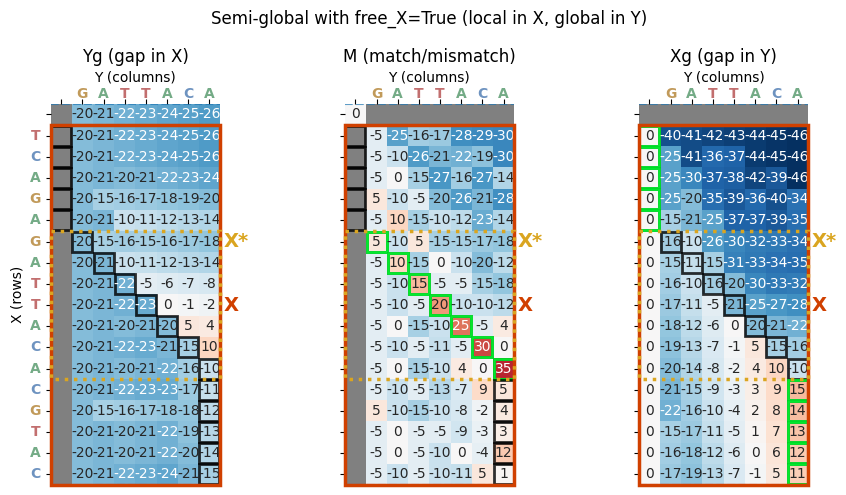

In [ ]:
# Visualize the DP matrices for semi-global alignment 
# Wrap result for plotting
res_sg_free = AlignmentResult(
    score=score_sg_free,
    X_aln=X_aln_sg,
    Y_aln=Y_aln_sg,
    jumps=jumps_sg,
    data=data_sg,
    path=path_sg,
)

# Determine X* boundaries from the aligned sequences
# Find which rows of X were actually used (non-gap characters in X_aln)
# The alignment tells us which substring of X was matched
x_pos = 0  # position in X
xstar_positions = []
for x_char, y_char in zip(X_aln_sg, Y_aln_sg):
    if x_char != '-':
        x_pos += 1
        if y_char != '-':  
            xstar_positions.append(x_pos)

xstar_start_sg = min(xstar_positions)
xstar_end_sg = max(xstar_positions)

regions_sg_free = [
    {'start': 1, 'end': len(X_sg), 'label': 'X', 'color': '#d04000'},
    {'start': xstar_start_sg, 'end': xstar_end_sg, 'label': 'X*',
     'color': GOLD, 'linestyle': ':', 'label_position': 'top'},
]

fig_sg_free = plot_flex_matrices(
    result=res_sg_free,
    X=X_sg,
    Y=Y_sg,
    s=0,
    e=len(X_sg),
    marker_size=14,
    figsize=fig_size,
    regions=regions_sg_free,
)
fig_sg_free.suptitle("Semi-global with free_X=True (local in X, global in Y)")
fig_sg_free.tight_layout(w_pad=2.0)
plt.show()

## Semi-global alignment with `free_Y` flag

The `free_Y=True` flag performs semi-global alignment that is "global in X, local in Y".
This:

1. Initializes `Yg[0, j] = 0` for all columns (free leading gaps in Y)
2. Allows traceback to start at any column in the final row

This is useful when the read $Y$ extends beyond the reference $X$. For example,
when a read partially overlaps the reference at either end. The unaligned portion
of $Y$ (the overhang) incurs no penalty.

Note: Unlike `free_X`, the `free_Y` mode cannot be achieved with EP patterns alone,
since EP operates on rows (reference positions), not columns (read positions).

In [ ]:
# Example of semi-global alignment with free_Y and free_X flag

X_sg = "GATTACA"
Y_sg = "ACACC"

# Build a standard EP pattern (no extra predecessors needed with free_Y)
EP_sg_test = build_EP_standard(len(X_sg))

# Run with free_Y=True (semi-global: global in X, local in Y)
config_sg_free = FlexInput(
    X=X_sg,
    Y=Y_sg,
    score_matrix=score_matrix,
    gap_open=gap_open,
    gap_extend=gap_extend,
    extra_predecessors=EP_sg_test,
    alphabet_to_index=alphabet_to_index,
    free_X=True,
    free_Y=True,  # <-- semi-global: local in Y
)

score_sg_free, X_aln_sg, Y_aln_sg, path_sg, jumps_sg, data_sg = run_flex_dp(
    config_sg_free,
    return_data=True,
).to_tuple()

print("Semi-global (free_Y=True) alignment:")
print(f"  X = {X_sg}")
print(f"  Y = {Y_sg}")
print(f"  Score: {score_sg_free}")
print(f"  X_aln: {X_aln_sg}")
print(f"  Y_aln: {Y_aln_sg}")
print()

# Compare with standard global alignment
config_sg_global = FlexInput(
    X=X_sg,
    Y=Y_sg,
    score_matrix=score_matrix,
    gap_open=gap_open,
    gap_extend=gap_extend,
    extra_predecessors=EP_sg_test,
    alphabet_to_index=alphabet_to_index,
    free_Y=False,  # standard global
)

score_sg_global, X_aln_global, Y_aln_global, _, _, _ = run_flex_dp(
    config_sg_global,
    return_data=True,
).to_tuple()

print("Standard global alignment:")
print(f"  Score: {score_sg_global}")
print(f"  X_aln: {X_aln_global}")
print(f"  Y_aln: {Y_aln_global}")
print()

Semi-global (free_Y=True) alignment:
  X = GATTACA
  Y = ACACC
  Score: 15.0
  X_aln: GATTACA--
  Y_aln: ----ACACC

Standard global alignment:
  Score: -26.0
  X_aln: GATTACA
  Y_aln: --ACACC



## Summary

- Extra predecessor sets $E(i)$ let us express different alignment
  modes (standard, $ A \cdot Z \cdot B $ flex, semiglobal) in a unified DP framework.
- The single-block EP pattern realizes
  $$
  S_{\mathrm{flex}}(X,Y)
  = \max_{Z^* \subseteq Z} \mathrm{NWG}(A \cdot Z^* \cdot B, Y)
  $$
  in a single pass.
- The semiglobal EP pattern uses a full-length flexible block so that
  the entire reference can flex while the read remains globally
  aligned.
- The `free_X` flag in `FlexInput` provide a simpler way to
  achieve semi-global alignment without EP edges:
  - `free_X=True`: local in X, global in Y (find best substring of X matching Y)
  - `free_Y=True`: global in X, local in Y (align all of Y to any part of X)

In the next notebook we confirm that the NW-flex satisfies the guarantee of identifying an optimal alignment over all substrings.